# The AD-AS curve and supply shocks

Imports and set magics:

In [78]:
import numpy as np
from scipy import optimize
import scipy.optimize as opt
import sympy as sm
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description of the AD-AS model 


**In a closed economy on the short run**

The AD-AS model is a model from macroeconomics that describes the relationship between aggregate demand (AD) and aggregate supply (AS) in the short run. The model can be used to analyze how changes in government spending, taxes and monetary policy affect the output, prices and employment.

The model below is inspired from the textbook "Introducing Advanced Macroeconomics - Growth and Business Cycles" by Peter Birch Sørensen og Hans Jørgen Whitta-Jacobsen. 

Following five equations describe a closed economy:

**1) The Fischer Equation**:

$$
r = i-\pi^{e}_{+1}
$$

**2) The general market equilibrium**

$$
y-\bar{y} = \alpha_1 (g-\bar{g}) - \alpha_2(r-\bar{r})
$$

**3) The Taylor Rule**

$$
i = \bar{r} + \pi^{e}_{+1} + h(\pi - \pi^*) + b(y- \bar{y})
$$

**4) The SRAS curve** which is derived from the Expectations-Augmented Phillips Curve

$$
\pi = \pi^e + \gamma (y-\bar{y}) + s
$$


**5) Assuming static inflation expectations in the economy**

$$
\pi^e = \pi_{-1}
$$




The **AD-curve** is given by a combination of equation 1), 2) and 3):

$$
y-\bar{y} = z-\alpha(\pi - \pi^*)
$$
where
$$
z = \frac{\alpha_1}{1+\alpha_2b}(g-\bar{g}), \alpha = \frac{\alpha_2 h}{1+\alpha_2b}
$$

The **AS-curve** is given by a combination of equation 4) and 5):

$$
\pi = \pi_{-1} + \gamma(y-\bar{y}) + s

Explanation of the two curves: The **AD curve** represents the relationship between output, Y, and aggregate demand, AD, while the **AS curve** represents the relationship between output, Y, and aggregate supply, AS. 

**Alpha** is a function of the sensitivity of real interest rates,**h** to changes in the output gap and the slope of the Phillips curve, **b**.

**Gamma** is the slope of the AS-curve and **s** represents supply shocks.


Equilibrium: The equilibrium condition for the AD-AS-model is where the two curves intersect.




## Analytical solution

I start by defing the AD- and AS-curve using the equations above:

In [79]:
#Defining the symbols using sympy
y, pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star = sm.symbols('y pi g b alpha1 alpha2 h s y_bar pi_star')

#Defining the AD-curve
z = alpha1/(1 + alpha2*b)*(g - y_bar)
alpha = alpha2*h/(1 + alpha2*b)
AD = y - y_bar - alpha*(pi - pi_star) - z

#Defining the AS-curve
gamma = sm.symbols('gamma')
AS = pi - pi_star + gamma*(y - y_bar) + s

I then derive the steady state equation. This is done by setting AD and AS equal to each other and then solving for y:

In [80]:
#Steady state equation
steady_state_eq = sm.solve(sm.Eq(AD, AS), y)[0]


I now use lambdify to turn it into a Python function:

In [81]:
#Using lambdify to define the SS function
#ss_func takes in the parameters of the model and returns the value of y at SS

ss_func = sm.lambdify((pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma), steady_state_eq)


I now want to study the AD-AS model when a supply shock hits the economy. I use ipywidgets to illustrate how a supply shock, s, affects the AD- and AS-curve. In period 0 the economy is in its long-term equilibrium. However, in period one the user can make a temporary, negative or positive supply shock in the range -5 to +5. Remember: A supply shock is negative when s > 0 and positive when s > 0.  S is 0 in period zero and two, but in period 1 the user can change the value.



In [82]:
#Defining functions for the AD and AS curves
def ad(y, pi, pi_star, alpha, alpha_1, alpha_2, b, g, g_bar, h):
    z = alpha_1 / (1 + alpha_2 * b) * (g - g_bar)
    return y - y_bar - z + alpha * (pi - pi_star)

def as_curve(y, pi, pi_1, gamma, s):
    return pi - pi_1 - gamma * (y - y_bar) - s

#Defining the parameter values
y_bar = 100
pi_star = 2
alpha_1 = 1
alpha_2 = 1
b = 1
g = 1
g_bar = 1
h = 1
alpha = alpha_2 * h / (1 + alpha_2 * b)
gamma = 0.5

#Defining a function to plot the AD and AS curves
def plot_ad_as(s):
    #Creating a range of output levels
    y_range = np.linspace(y_bar - 10, y_bar + 10, 100)

    #Deriving the AD and AS curves
    ad_curve = ad(y_range, pi_star, pi_star, alpha, alpha_1, alpha_2, b, g, g_bar, h)
    as_curve_0 = as_curve(y_range, pi_star, pi_star, gamma, 0)
    as_curve_1 = as_curve(y_range, pi_star, pi_star, gamma, s)

    #Plotting
    plt.plot(y_range, ad_curve, label='AD')
    plt.plot(y_range, as_curve_0, label='AS (s=0)', color='grey')
    plt.plot(y_range, as_curve_1, label='AS (s={:.2f})'.format(s), color='red')

    
    plt.xlabel('Output')
    plt.ylabel('Inflation')
    plt.legend()

#Creating the interactive plot with a slider 
interact(plot_ad_as, s=FloatSlider(min=-5, max=5, step=0.1, value=0));


interactive(children=(FloatSlider(value=0.0, description='s', max=5.0, min=-5.0), Output()), _dom_classes=('wi…

It is worth noting, that the AD curve is upward sloping and the AS curve is downward sloping in this model. This is due to the assumptions that are made. For example, an increase in the price level leads to an increase in aggregate demand. This can be counterintuitive, because one would think a higher price level leads to a decrease in demand. But in this case, it is due to the effect of higher inflation on the real interest rate, which thereby affects consumption and investments.




## Numerical solution

To solve an optimization problem in a AD-AS model, it is very appropriate to look a the social loss function. The social loss function measures the welfare loss that the society experiences due to the economy deviating from its optimal state. It is therefore essential to minimize the social loss function. This can be done by finding the optimal parameter values, that minimixes the following equation:

$$
L=(\pi-\pi^{*})^{2}+a(y-\bar{y})^{2}

$$

Where $\pi$ is the actual inflation rate, $\pi^{*}$ is the target inflation rate, $y$ is the actual output level, $\bar{y}$ is the natural output level and $a$ is a parameter that determines the weight given to the output gap in the loss function.

In [83]:
# Fixing the parameter values
pi = 0.02
b = 0.5
alpha2 = 1
h = 0.5
s = 0
y_bar = 100 
pi_star = 0.02
gamma = 0.5

# Defining the social loss function with fixed parameters
def social_loss(args):
    g, alpha1 = args
    y = ss_func(pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma)
    return (y_bar - y) ** 2 + (pi_star - pi) ** 2

# Initial values for the varying parameters
initial_g = 0.03
initial_alpha1 = 1.5

# Optimizing the social loss function with respect to g and alpha1 using the trust-constr method
optimal_par_gh = opt.minimize(social_loss, [initial_g, initial_alpha1], method='trust-constr')

print("The optimal parameter values that minimize the social loss are:")
print("g:", optimal_par_gh.x[0])
print("alpha1:", optimal_par_gh.x[1])




The optimal parameter values that minimize the social loss are:
g: 0.04500637346159248
alpha1: 1.8421020773482135e-12


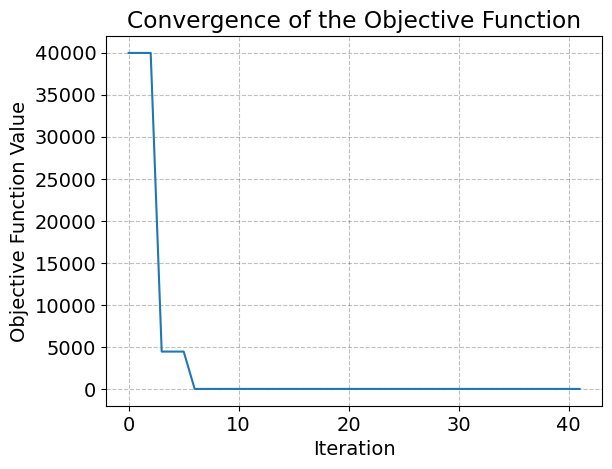

In [84]:
import matplotlib.pyplot as plt

# Perform the optimization and collect the objective function values
history = []

def social_loss(args):
    g, alpha1 = args
    y = ss_func(pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma)
    loss = (y_bar - y) ** 2 + (pi_star - pi) ** 2
    history.append(loss)  # Collect the objective function value
    return loss

optimal_par_gh = opt.minimize(social_loss, [initial_g, initial_alpha1], method='trust-constr')

# Plot the convergence of the objective function
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence of the Objective Function")
plt.show()


In [88]:
# #OLD !!!! Defining the social loss function
# def social_loss(args):
#     pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma = args
#     y = ss_func(pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma)
#     return (y_bar - y)**2 + (pi_star - pi)**2

# #Defining initial parameter values
# pi = 0.02
# g = 0.03
# b = 0.5
# alpha1 = 1.5
# alpha2 = 1
# h = 0.5
# s = 0
# y_bar = 1
# pi_star = 0.02
# gamma = 0.5

# #Optimizing the social loss function using the Nelder-Mead method
# optimal_par = opt.minimize(social_loss, [pi, g, b, alpha1, alpha2, h, s, y_bar, pi_star, gamma], method='Nelder-Mead')

# # Print the optimal parameter values
# print("The optimal parameter values that minimize the social loss are:", optimal_par.x)

The optimal parameter values that minimize the social loss are: [0.02321371 0.03382991 0.70061025 0.00670146 1.41716115 0.53288151
 0.00158333 0.50487948 0.02321361 0.37929403]


# Conclusion

Add concise conclusion. 